# Trials on real data

January 2022

gully


In [1]:
%config Completer.use_jedi = False

In [2]:
import torch
from blase.emulator import PhoenixEmulator, SparsePhoenixEmulator
import matplotlib.pyplot as plt
from gollum.phoenix import PHOENIXSpectrum
import numpy as np
from tqdm.notebook import tqdm

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
    
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
device

'cuda'

### Make a tensor composed of $N_{lines}$ sparsely spaced spectral lines.

I have experimentally verified that this notebook works with up to 500,000 lines.  You may wish to turn off overplotting all the lines for $N_{lines}>500$.  Also, the amplitudes become unphysical and the spectrum can become negative because we are adding flux loss and not opacity.

In [4]:
spectrum = PHOENIXSpectrum(teff=4700, logg=4.5)#, wl_lo=8019, wl_hi=12845)
spectrum = spectrum.divide_by_blackbody()
spectrum = spectrum.normalize()
continuum_fit = spectrum.fit_continuum(polyorder=5)
spectrum = spectrum.divide(continuum_fit, handle_meta="ff")

In [5]:
active_lower, active_upper = 8079, 12785
line_threshold_lower, line_threshold_upper = 8049, 12815

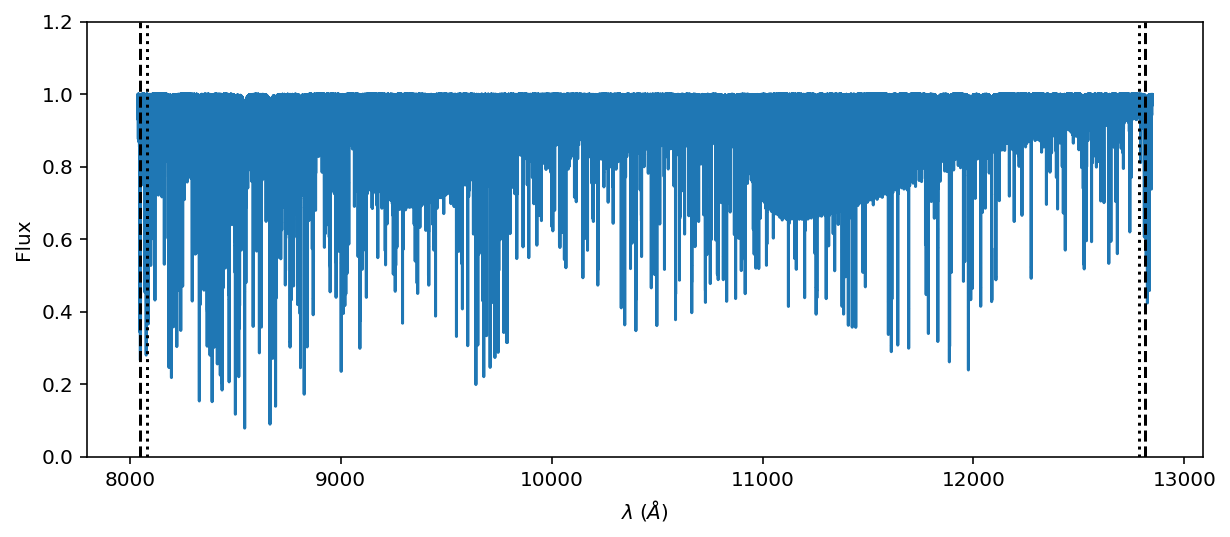

In [6]:
ax = spectrum.plot(ylo=0);
ax.axvline(8049, linestyle='dashed', color='k')
ax.axvline(12815, linestyle='dashed', color='k')

ax.axvline(8079, linestyle='dotted', color='k')
ax.axvline(12785, linestyle='dotted', color='k');

In [7]:
# Numpy arrays: 1 x N_pix
wl_native = spectrum.wavelength.value
flux_native = spectrum.flux.value

In [8]:
emulator = SparsePhoenixEmulator(wl_native, flux_native, prominence=0.01)

Initializing a sparse model with 9028 spectral lines


In [9]:
emulator.to(device)

SparsePhoenixEmulator()

In [10]:
state_dict_init = emulator.state_dict()

In [11]:
state_dict_init['lam_centers'].shape

torch.Size([9028])

In [12]:
state_dict_post = torch.load('../examples/sparse_T4700g4p5_prom0p01_HPF.pt')

In [13]:
emulator.load_state_dict(state_dict_post)

<All keys matched successfully>

In [14]:
%%time
with torch.no_grad():
    spec_out = emulator.forward().cpu().numpy()

CPU times: user 18.7 ms, sys: 0 ns, total: 18.7 ms
Wall time: 17.5 ms


## Read in real data

In [15]:
from muler.hpf import HPFSpectrum

In [16]:
raw_data = HPFSpectrum(file='../test/data/Goldilocks_20191022T014138_v1.0_0004.spectra.fits', order=4)

In [17]:
data = raw_data.sky_subtract().deblaze().normalize().trim_edges((8,2040))

In [18]:
wl = emulator.wl_native[emulator.active_mask].numpy()
flux = emulator.flux_native[emulator.active_mask].numpy()

In [19]:
from blase.emulator import EchelleModel

In [20]:
model = EchelleModel(data.wavelength.value, pretrained_emulator=emulator)

In [21]:
model.to(device)

EchelleModel(
  (emulator): SparsePhoenixEmulator()
)

In [22]:
%%time
with torch.no_grad():
    output = model.forward()[emulator.active_mask.cpu().numpy()]

CPU times: user 282 ms, sys: 84.6 ms, total: 367 ms
Wall time: 367 ms


(8534.80423111262, 8644.209998667306)

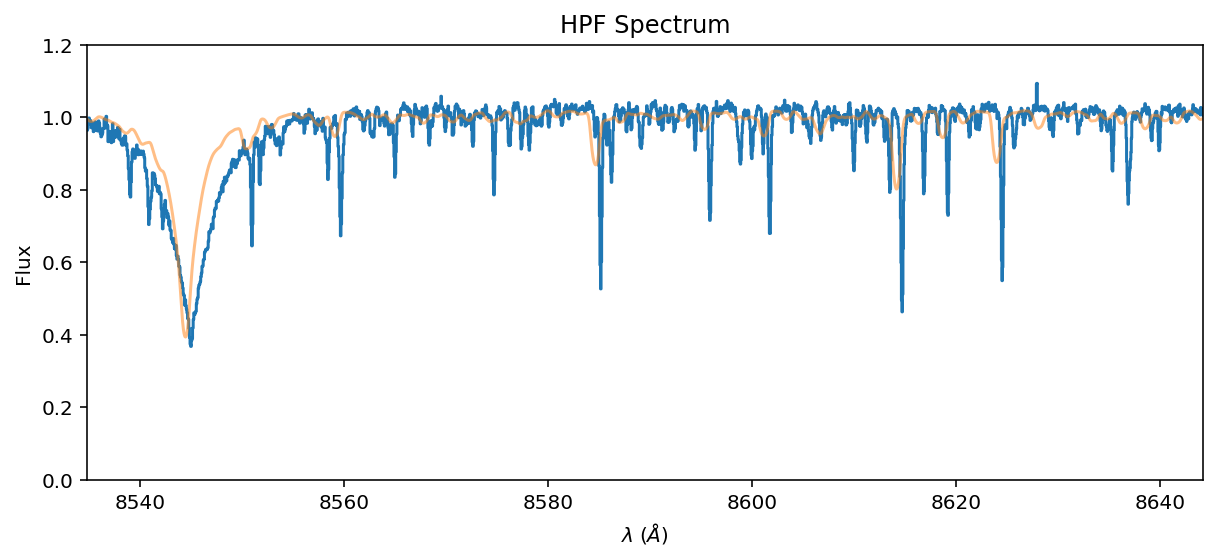

In [23]:
ax = data.plot(ylo=0);
ax.plot(wl, output.cpu()/np.median(output.cpu()), alpha=0.5, label = 'Native')
ax.set_xlim(data.wavelength.value.min(), data.wavelength.value.max())

Yay! We have doctored the emulator model to work with real data. The next step is adding in the doppler shift and then it should be ready for training!